In [1]:
import sys
sys.path.append('../')
from _imports import *

In [80]:
train_X = pd.read_csv('../data/preprocess/train_X.csv').to_numpy()
train_X_nas: np.ndarray = pd.read_csv('../data/preprocess/na/X.csv').eq(1).to_numpy()
train_y = pd.read_csv('../data/preprocess/train_y.csv').iloc[:, 0].to_numpy()

FileNotFoundError: [Errno 2] No such file or directory: '../data/preprocess/na/X.csv'

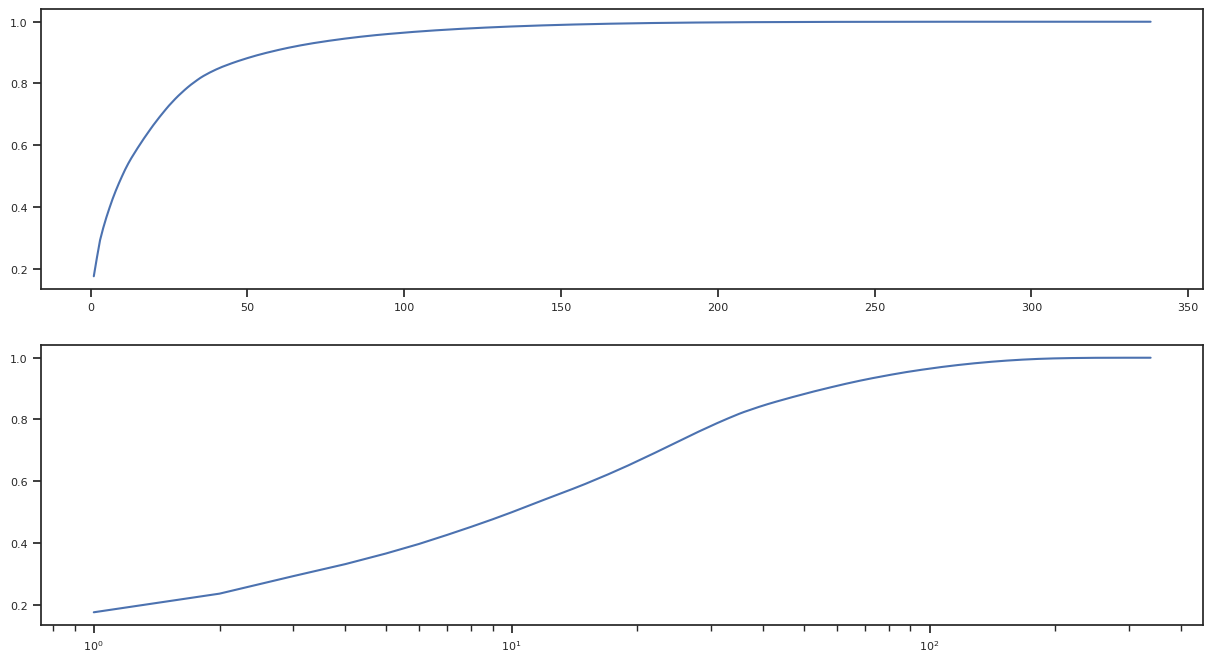

In [56]:
pca = PCA(random_state=0)
pca.fit(X)
costs = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(15, 8))
plt.subplot(2,1,1)
sns.lineplot(x=range(1, pca.n_components_+1), y=costs)
plt.subplot(2,1,2)
sns.lineplot(x=range(1, pca.n_components_+1), y=costs).set(xscale="log")
plt.show()

In [17]:
# this is not optimized:
n_features = train_X.shape[1]
costs = np.zeros((n_features, 3))
for i in range(n_features):
  pca = PCA(n_components=(i + 1), svd_solver='full', random_state=0)
  diff = pca.inverse_transform(pca.fit_transform(train_X)) - train_X
  costs[i] = [
    np.max(np.abs(diff)),
    np.mean(np.abs(diff)),
    np.sqrt(np.mean(diff ** 2)),
  ]
costs

array([[3.81967827e+01, 1.71055846e-01, 4.08258621e-01],
       [3.81738247e+01, 1.64863390e-01, 3.93022974e-01],
       [3.80868175e+01, 1.59677063e-01, 3.78171510e-01],
       ...,
       [7.92144128e-14, 8.97457059e-16, 1.80187674e-15],
       [7.92144128e-14, 8.97800670e-16, 1.80193497e-15],
       [7.92144128e-14, 8.97878693e-16, 1.80197724e-15]])

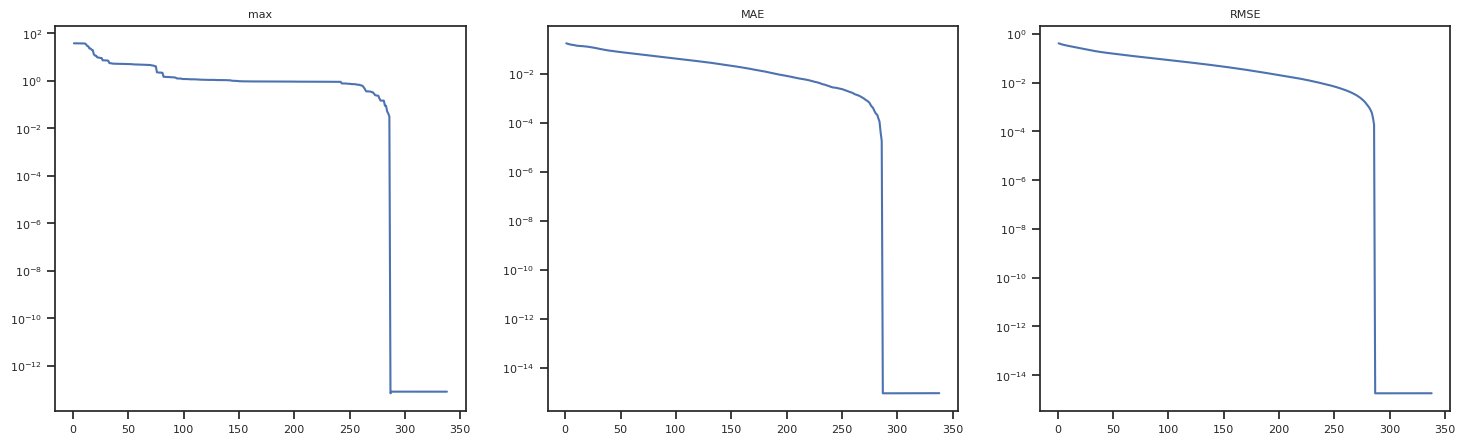

In [25]:
plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
sns.lineplot(x=range(1,n_features+1), y=costs[:,0]).set(yscale="log")
plt.title("max")
plt.subplot(1,3,2)
sns.lineplot(x=range(1,n_features+1), y=costs[:,1]).set(yscale="log")
plt.title("MAE")
plt.subplot(1,3,3)
sns.lineplot(x=range(1,n_features+1), y=costs[:,2]).set(yscale="log")
plt.title("RMSE")
plt.show()

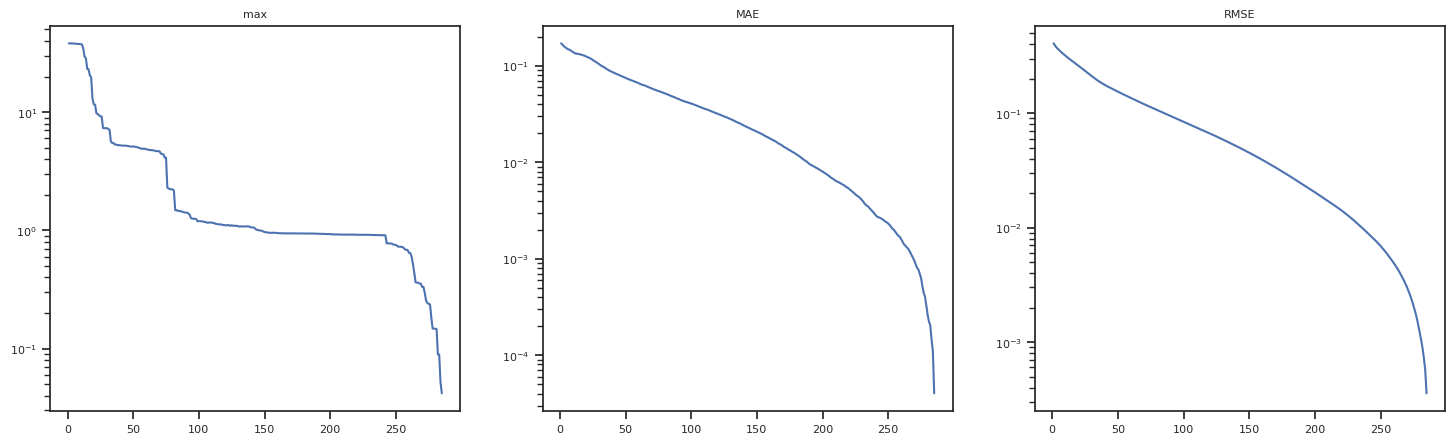

In [36]:
limit = 285
plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
sns.lineplot(x=range(1,limit+1), y=costs[:limit,0]).set(yscale="log")
plt.title("max")
plt.subplot(1,3,2)
sns.lineplot(x=range(1,limit+1), y=costs[:limit,1]).set(yscale="log")
plt.title("MAE")
plt.subplot(1,3,3)
sns.lineplot(x=range(1,limit+1), y=costs[:limit,2]).set(yscale="log")
plt.title("RMSE")
plt.show()

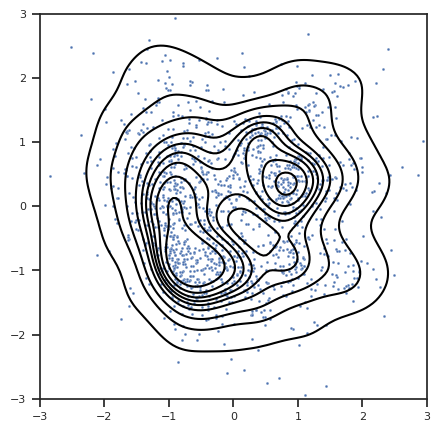

In [60]:
pca = PCA(n_components=2, whiten=True, random_state=0)
Z = pca.fit_transform(train_X)

plt.figure()
sns.scatterplot(x=Z[:,0], y=Z[:,1], s=4)
sns.kdeplot(x=Z[:,0], y=Z[:,1], color="black")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

In [68]:
def pca_impute(X, Xna, ncomp, niter):
  costs = np.zeros((niter, 2))
  Xf = X.copy()
  for i in range(niter):
    pca = PCA(n_components=ncomp, random_state=i)
    filtered = pca.inverse_transform(pca.fit_transform(Xf))
    nXf = Xf.copy()
    nXf[Xna] = filtered[Xna]
    
    diff = math.sqrt(((nXf[Xna] - Xf[Xna])**2).mean())
    diff0 = math.sqrt(((nXf[Xna] - X[Xna])**2).mean())
    # print("{:02d} - {:.8f} - {:.8f}".format(i + 1, diff0, diff))
    costs[i,0] = diff0
    costs[i,1] = diff
    
    Xf = nXf
  return Xf, costs

In [69]:
def show_pca_impute(ncomp, niter, costs):
  plt.figure(figsize=(12, 5))
  plt.suptitle(f'ncomp = {ncomp}')
  plt.subplot(1, 2, 1)
  sns.lineplot(x=range(1, niter + 1), y=costs[:,0]);
  plt.title("diff0")
  plt.subplot(1, 2, 2)
  sns.lineplot(x=range(1, niter + 1), y=costs[:,1]);
  plt.title("diff")
  plt.show()

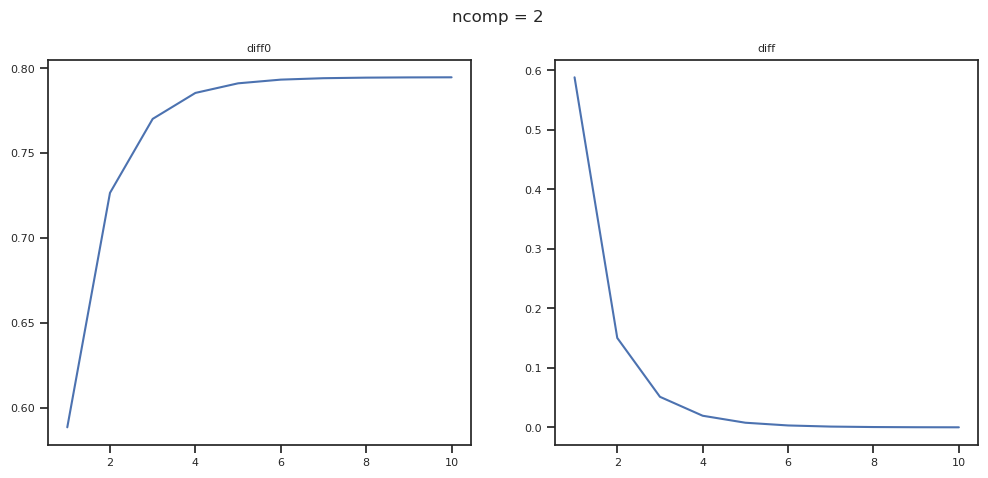

In [70]:
Xf, costs = pca_impute(train_X, train_X_nas, 2, 10)
show_pca_impute(2, 10, costs)

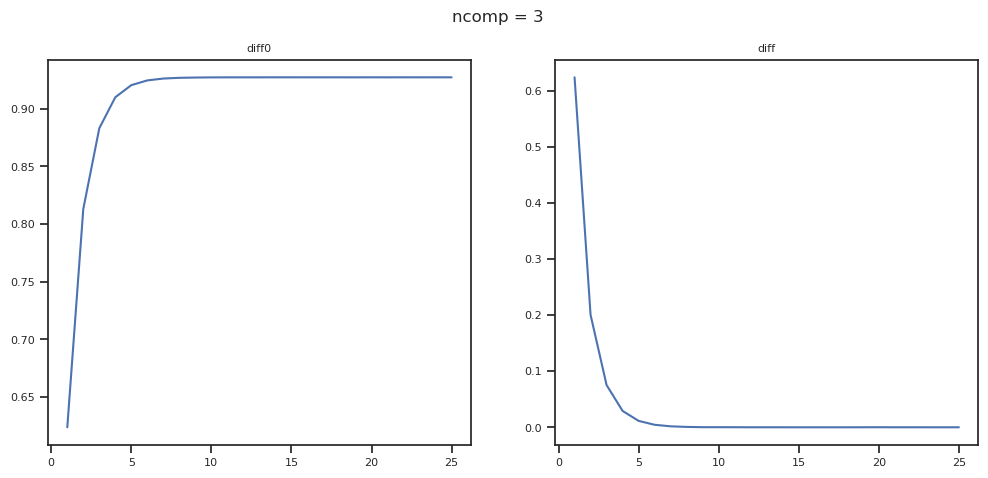

In [76]:
Xf, costs = pca_impute(train_X, train_X_nas, 3, 25)
show_pca_impute(3, 25, costs)

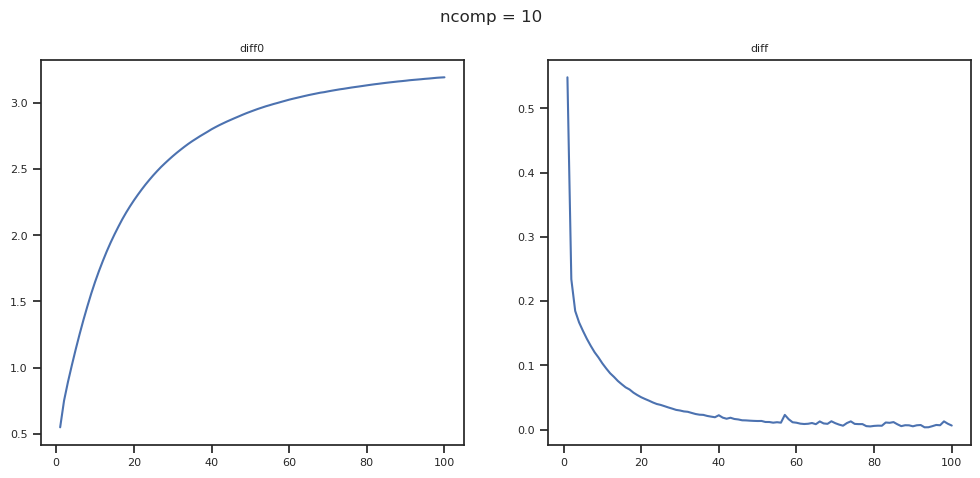

In [71]:
Xf, costs = pca_impute(train_X, train_X_nas, 10, 100)
show_pca_impute(10, 100, costs)

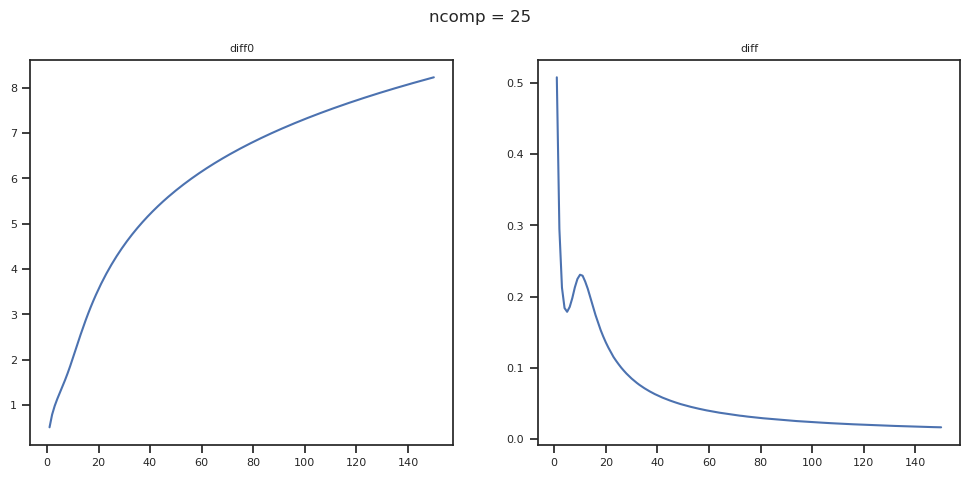

In [73]:
Xf, costs = pca_impute(train_X, train_X_nas, 25, 150)
show_pca_impute(25, 150, costs)

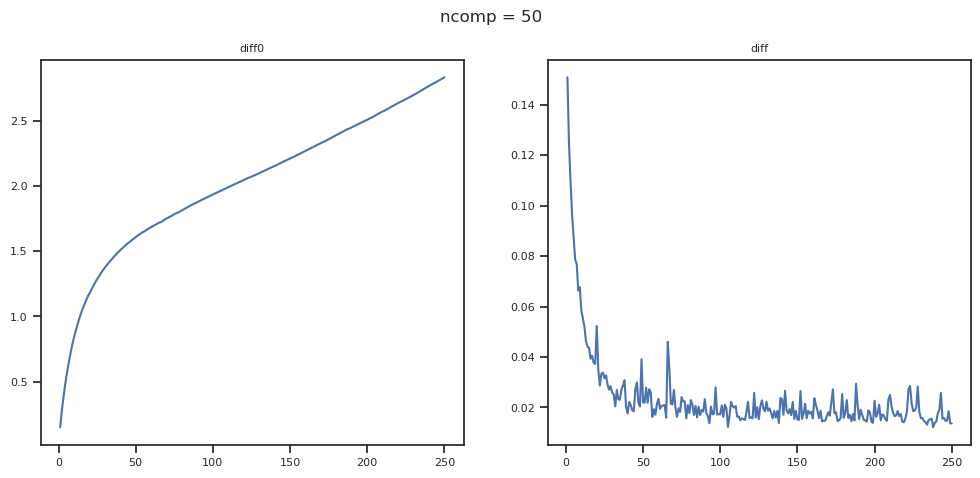

In [74]:
Xf, costs = pca_impute(train_X, train_X_nas, 50, 250)
show_pca_impute(50, 250, costs)

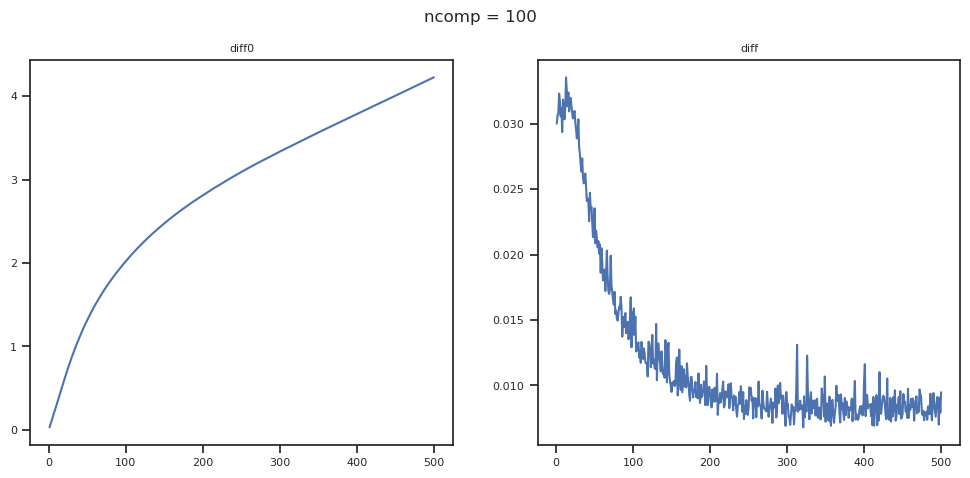

In [75]:
Xf, costs = pca_impute(train_X, train_X_nas, 100, 500)
show_pca_impute(100, 500, costs)

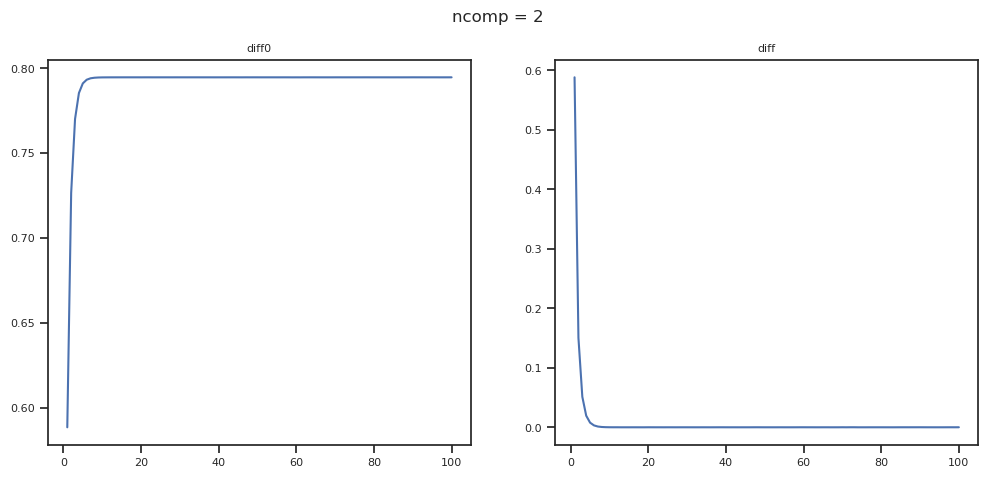

In [79]:
Xf, costs = pca_impute(train_X, train_X_nas, 2, 100)
show_pca_impute(2, 100, costs)

In [81]:
m = RandomForestRegressor(
  n_estimators=1000,
  criterion='squared_error',
  max_depth=16,
  max_features='sqrt',
  bootstrap=True,
  oob_score=True,
  n_jobs=-1,
  max_samples=0.9,
  ccp_alpha=0.0,
  random_state=1,
)

m.fit(train_X, train_y)

m.oob_score_

0.869475943581316

In [82]:
m = RandomForestRegressor(
  n_estimators=1000,
  criterion='squared_error',
  max_depth=16,
  max_features='sqrt',
  bootstrap=True,
  oob_score=True,
  n_jobs=-1,
  max_samples=0.9,
  ccp_alpha=0.0,
  random_state=1,
)

m.fit(Xf, train_y)

m.oob_score_

0.8686002375086777